# Who survives in the titanic?

> Aim of this notebook is to practice coding in python and ML classification techniques

From a top level, this will follow the workflow: 

    1. Data exploration
    2. Feature engineering
    3. Train ML model 
    4. Predict using ML model 
    5. Evaluate predictions

In [1]:
import pandas as pd
import numpy as np

# Regular expressions
import re

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# Preprocessing
from sklearn.preprocessing import LabelEncoder

# ML model training
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn import metrics 

## Data exploration

In [2]:
# load in the data and overview of the data structure
train = pd.read_csv("/Users/DZ_laptop/Dropbox/DZ_Work/kaggle/getting_started_kaggle/titanic/raw_data/train.csv")
test = pd.read_csv("/Users/DZ_laptop/Dropbox/DZ_Work/kaggle/getting_started_kaggle/titanic/raw_data/test.csv")

In [3]:
print(train.shape) # what are the dimensions/number of training examples?
train.head() # what features do we have?

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(test.shape)
test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# combine train and test together to use all the most data possible for feature exploration/engineering
data = pd.concat([train, test], sort = True).reset_index(drop = True)

### Which columns have missing variables?

In [6]:
for col in data.columns:
    
    print("{} has {} missing values".format(col, str(data[col].isna().sum())))

Age has 263 missing values
Cabin has 1014 missing values
Embarked has 2 missing values
Fare has 1 missing values
Name has 0 missing values
Parch has 0 missing values
PassengerId has 0 missing values
Pclass has 0 missing values
Sex has 0 missing values
SibSp has 0 missing values
Survived has 418 missing values
Ticket has 0 missing values


### Correlation between numeric features

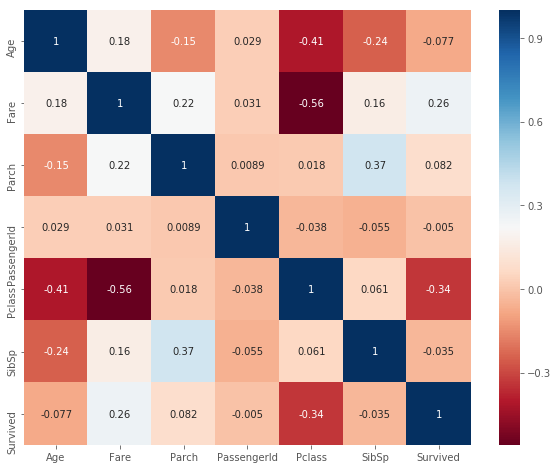

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr("pearson"), 
            cmap = "RdBu", 
            annot = True)

- Fare and Pclass stand out as correlated with the output variable survival. Intuitively, richer passengers are likely to have a greater likelihood of survival. 

## Feature engineering

### Sex

count     1309
unique       2
top       male
freq       843
Name: Sex, dtype: object
Sex
female    466
male      843
Name: PassengerId, dtype: int64
Sex     Survived
female  0.0          81
        1.0         233
male    0.0         468
        1.0         109
Name: PassengerId, dtype: int64


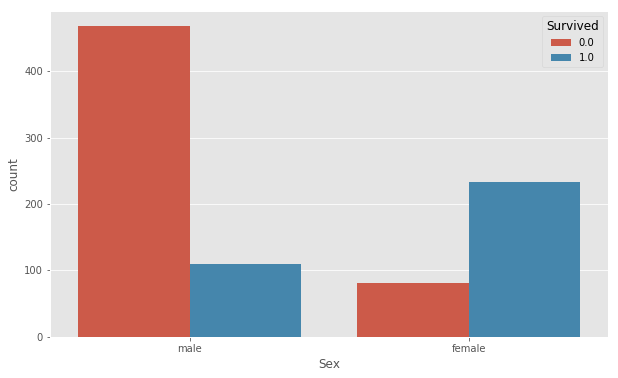

In [8]:
print(data["Sex"].describe())
print(data.groupby("Sex").PassengerId.count())
print(data.groupby(["Sex", "Survived"]).PassengerId.count()) # a much higher proportion of F survived

plt.figure(figsize=(10, 6))
sns.countplot(x = "Sex", hue = "Survived", data = data) # Looks like an important feature 
data["Sex"] = LabelEncoder().fit_transform(data["Sex"]) # convert Sex to numeric 1/0s

- Based on the count plot, it looks as though females have a higher likelihood of survival. Perhaps they were preferentially offered to leave the ship first

### Name

- Each name is labelled with a title. This may inform both the gender of the person, as well as the age and the status/wealth, all factors that may affect survival

In [9]:
# extract title from names
data["Title"] = data["Name"].apply(lambda name: re.sub(".*, ", "", name)).apply(lambda name: re.sub("\\..*", "", name))
data["Title"] = data["Title"].apply(lambda title: "Miss" if title == "Ms" else title) # convert 2 Ms to Miss
data["Title"] = data["Title"].apply(lambda title: "other" if title not in ["Master", "Miss", "Mr", "Mrs", "Ms"] else title) # group "other" 

data.groupby("Title").Name.count()

Title
Master     61
Miss      262
Mr        757
Mrs       197
other      32
Name: Name, dtype: int64

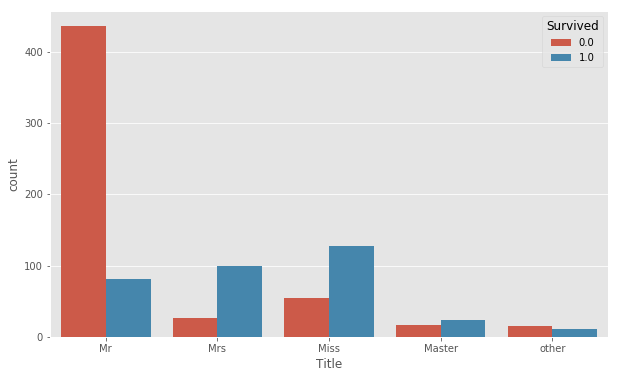

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(x = "Title", hue = "Survived", data = data) # again looks informative for survival, with females disproportionately saved

In [11]:
# Encode the title data to integer - perhaps better as dummy? 
data["Title"] = LabelEncoder().fit_transform(data["Title"])
data = data.drop(columns = "Name") # remove the name variable

### Age

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64


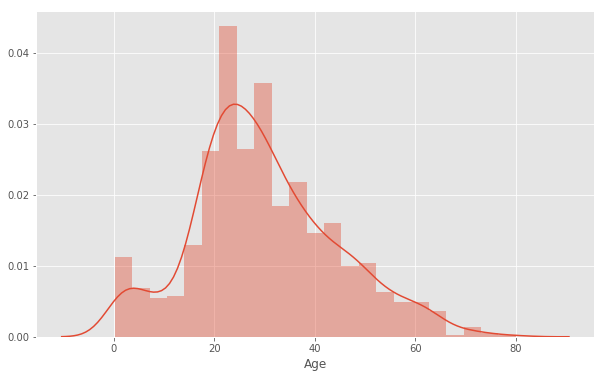

In [12]:
print(data["Age"].describe()) 
plt.figure(figsize=(10, 6))
sns.distplot(data["Age"][data["Age"].notna()]) # plot the non-NAs 

In [13]:
data.corr()

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title
Age,1.000000,0.178740,-0.150917,0.028814,-0.408106,0.063645,-0.243699,-0.077221,0.509109
Fare,0.178740,1.000000,0.221539,0.031428,-0.558629,-0.185523,0.160238,0.257307,0.029900
Parch,-0.150917,0.221539,1.000000,0.008942,0.018322,-0.213125,0.373587,0.081629,-0.088875
PassengerId,0.028814,0.031428,0.008942,1.000000,-0.038354,0.013406,-0.055224,-0.005007,0.039751
Pclass,-0.408106,-0.558629,0.018322,-0.038354,1.000000,0.124617,0.060832,-0.338481,-0.219885
Sex,0.063645,-0.185523,-0.213125,0.013406,0.124617,1.000000,-0.109609,-0.543351,0.014544
SibSp,-0.243699,0.160238,0.373587,-0.055224,0.060832,-0.109609,1.000000,-0.035322,-0.194396
Survived,-0.077221,0.257307,0.081629,-0.005007,-0.338481,-0.543351,-0.035322,1.000000,-0.058000
Title,0.509109,0.029900,-0.088875,0.039751,-0.219885,0.014544,-0.194396,-0.058000,1.000000


- Age is most correlated with the Title feature. Let's use the title to fill in the missing ages

In [14]:
# fill in column with grouped mean of another column
def fill_na_col(data, col_to_fill, group_col):
    
    grouped_mean = data.groupby(group_col).Age.mean()

    col_filled = list()

    for i in range(len(data)):
    
        if np.isnan(data.iloc[i][col_to_fill]):

            col_filled.append(grouped_mean[data.iloc[i][group_col]])

        else:

            col_filled.append(data.iloc[i][col_to_fill])
    
    data[col_to_fill] = col_filled
    
    return data
    
data = fill_na_col(data = data, col_to_fill = "Age", group_col = "Title")

### SibSp & Parch

- **SibSp** is the number of siblings also aboard the titanic
- **Parch** is the number of Parents/Children

In [15]:
print(data.groupby("Parch").Sex.count())
print(data.groupby("SibSp").Sex.count())

Parch
0    1002
1     170
2     113
3       8
4       6
5       6
6       2
9       2
Name: Sex, dtype: int64
SibSp
0    891
1    319
2     42
3     20
4     22
5      6
8      9
Name: Sex, dtype: int64


In [16]:
# 1/2 are weighted by the children, since they have either 1/2 parents on board, as you can also see from the lower ages
print(data.groupby("Parch").Age.min()) 

Parch
0     5.000000
1     0.420000
2     0.170000
3    16.000000
4    29.000000
5    38.000000
6    40.000000
9    32.252151
Name: Age, dtype: float64


In [17]:
# Using both the Age and the Parch, let's reclassify these as child vs parents
data["child"] = data.apply(lambda row: 1 if (row.Age <= 15) and (row.Parch < 3) else 0, axis = 1)
data["parent"] = data.apply(lambda row: 1 if (row.Age >= 22) and (row.Parch > 0) else 0, axis = 1)
data["single"] = data.apply(lambda row: 1 if (row.SibSp + row.Parch) == 0 else 0, axis = 1)

data[["child", "parent", "single", "Survived"]].corr()

,child,parent,single,Survived
child,1.000000,-0.118887,-0.343796,0.136884
parent,-0.118887,1.000000,-0.455463,0.094018
single,-0.343796,-0.455463,1.000000,-0.203367
Survived,0.136884,0.094018,-0.203367,1.000000


### Pclass

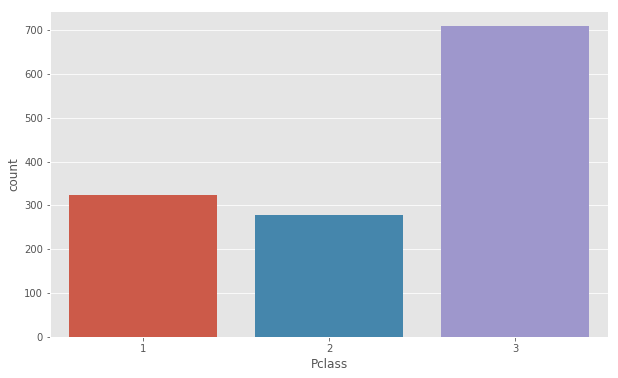

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(data["Pclass"])

### Fare

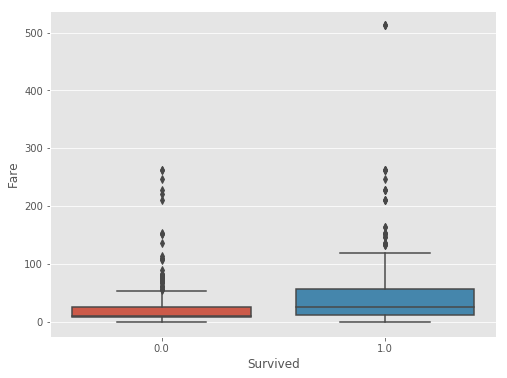

In [19]:
plt.figure(figsize=(8, 6))
sns.boxplot(data["Survived"], data["Fare"])

In [20]:
data[data["Fare"].isna()] # missing row

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,child,parent,single
1043,60.5,NaN,S,NaN,0,1044,3,1,0,NaN,3701,2,0,0,1


In [21]:
# fill in the missing line with the mean of dependent on Pclass
data["Fare"] = data.apply(lambda row: data.groupby("Pclass").Fare.mean()[row.Pclass] if np.isnan(row.Fare) else row.Fare, axis = 1)

### Embarked

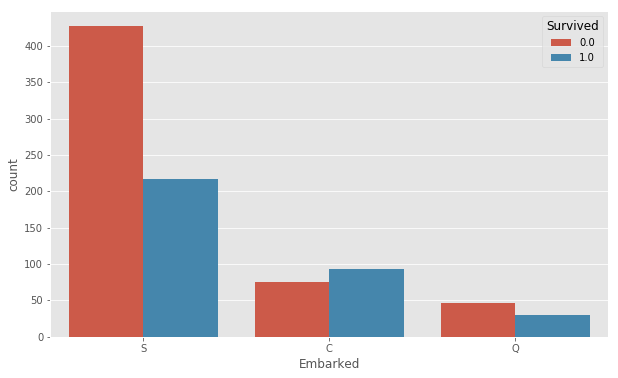

In [22]:
# S embarking seems to have detrimental effect on survival
plt.figure(figsize=(10, 6))
sns.countplot(x = "Embarked", data = data, hue = "Survived")

In [23]:
# S is not the least expensive on average
print(data.groupby("Embarked").Fare.mean())
data.groupby(["Embarked", "Pclass"]).PassengerId.count()

Embarked
C    62.336267
Q    12.409012
S    27.403380
Name: Fare, dtype: float64


Embarked  Pclass
C         1         141
          2          28
          3         101
Q         1           3
          2           7
          3         113
S         1         177
          2         242
          3         495
Name: PassengerId, dtype: int64

In [24]:
data[data.Embarked.isna()]

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,child,parent,single
61,38.0,B28,NaN,80.0,0,62,1,0,0,1.0,113572,1,0,0,1
829,62.0,B28,NaN,80.0,0,830,1,0,0,1.0,113572,3,0,0,1


In [25]:
# Based on both Fare and class let's fill the NA's in with C's
data.Embarked = data.Embarked.apply(lambda x: "C" if pd.isnull(x) else x)

In [26]:
# Make Embarked a dummy variable 
data = pd.concat([data, pd.get_dummies(data.Embarked)], axis = 1)
data = data.drop(columns = "Embarked")

### Ticket, Cabin

- These variables look uninformative in terms of predicting survival.
    - Ticket seems like it would require severe wrangling to obtain any patterns or ML processable data
    - Cabin has many missing values

In [27]:
data = data.drop(columns = ["Ticket", "Cabin"])

## Train ML model

### Split data back into train/test/valid

In [28]:
# split data back into train and test 
train = data[data.Survived.notna()]
train = train.drop(columns = "PassengerId")
test = data[data.Survived.isna()]

In [29]:
# split the train into train and validation datasets 
# validation to get a local estimate of ML model performance
train, valid = train_test_split(train, # DataFrame to split
                                      test_size = 0.2, # proportion to split 
                                      random_state = 32) 
print(train.shape)
print(valid.shape)

(712, 14)
(179, 14)


### Hyperparamater tuning

- Random forest top-level intuition is well explained in: https://towardsdatascience.com/understanding-random-forest-58381e0602d2 
    - Random forest is an ensemble of decision trees. Each decision tree operates by splitting the data based on the features that would result in groups being as different from each other as possible. Then having an outputted class at the end of each "branch". 
    - Random forest performs better by having uncorrelated decision trees voting together for the class a particular sample. The uncorrelated nature of the single individual trees allows for individual errors to be masked - "wisdom of crowds" 
    - The uncorrelated nature of indivudual decision trees is attained through bagging (bootstrap aggregation) and feature randomness: 
        1. Bagging is randomly sampling the an N number of samples with replacement. For example a dataset of samples 1, 2, 3, 4, 5 may be bagged to 2, 2, 4, 3, 3. Note: the N remains as 5 samples.
        2. Feature randomness works by not allowing each decision tree access to the entire set of features, only a random subset of these. 
    
- More detail and mathematical concepts can be found in: https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76 

- Following https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74: 
    1. Tune hyperparameters over a large range through RandomizedSearchCV() to save computing time
    2. Then hone in on the local optima found by 1 using GridSearchCV() to search across all values near that optima

In [30]:
model = RandomForestClassifier(random_state = 42)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ["auto", "log2"]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

clf_random = RandomizedSearchCV(estimator = model, 
                                param_distributions = random_grid, 
                                n_iter = 100, 
                                cv = 3, 
                                n_jobs = 4, 
                                random_state = 42)

# Fit the random search model
clf_random.fit(train.drop(columns = "Survived"), train["Survived"])

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=4,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [31]:
clf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 110,
 'bootstrap': True}

In [32]:
# Create the parameter grid based on the results of random search 
parameters = dict(n_estimators = [500, 550, 600, 650, 700],
                  max_features = ["auto", "log2"],
                  min_samples_leaf = [1, 2, 3],
                  min_samples_split = [8, 10, 12], 
                  max_depth = [90, 100, 110, 120, 130, None], 
                  bootstrap = ["True"])

# do cross validation to search for optimal hyperparams
grid = GridSearchCV(estimator = model, 
                    param_grid = parameters,
                    scoring = 'accuracy', # which score to optimise for 
                    cv = 5, # k-fold cross validation validation 
                    n_jobs = 4) # parrellel over 4 cores

grid.fit(train.drop(columns = "Survived"), train["Survived"])

clf = grid.best_estimator_

print(clf) # tuned estimator 

RandomForestClassifier(bootstrap='True', class_weight=None, criterion='gini',
            max_depth=90, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


   features  importance
0       Sex    0.270324
1      Fare    0.172597
2     Title    0.156927
3       Age    0.127399
4    Pclass    0.111806
5     SibSp    0.054738
6     Parch    0.023150
7    single    0.018383
8         S    0.018015
9         C    0.017464
10    child    0.013837
11        Q    0.007881
12   parent    0.007480


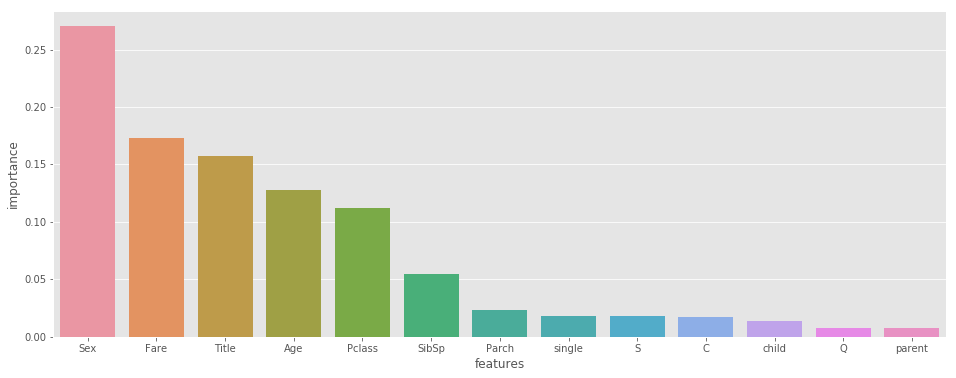

In [33]:
feat_imp = pd.DataFrame({"features" : train.drop(columns = "Survived").columns, 
                        "importance": clf.feature_importances_})
feat_imp = feat_imp.sort_values(['importance'], ascending = False).reset_index(drop=True)

print(feat_imp)

plt.figure(figsize=(16, 6))
sns.barplot(x = "features", y = "importance", data = feat_imp)

### Predict 

In [34]:
# predict on validation set for local evaluation of model performance
valid_pred = clf.predict(valid.drop(columns = "Survived"))

# obtain the actual prediction probabilities 
valid_pred_prob = clf.predict_proba(valid.drop(columns = "Survived"))
print(valid_pred_prob[0:10]) # array of N,2 with the probability of each person being either class 1 or 0

[[0.95862937 0.04137063]
 [0.03067802 0.96932198]
 [0.01044413 0.98955587]
 [0.92720672 0.07279328]
 [0.95981555 0.04018445]
 [0.05743188 0.94256812]
 [0.39008966 0.60991034]
 [0.90542519 0.09457481]
 [0.97945686 0.02054314]
 [0.68673797 0.31326203]]


In [35]:
# get predictions for test set to submit on kaggle
#grid.fit(pd.concat([train, valid]).drop(columns = "Survived"), 
#         pd.concat([train, valid])["Survived"]) # train entire set of training examples

#print(grid.best_estimator_)

test.Survived = clf.predict(test.drop(columns = ["PassengerId", "Survived"])).astype(int)
test[["PassengerId", "Survived"]].to_csv("/Users/DZ_laptop/Dropbox/DZ_Work/kaggle/getting_started_kaggle/titanic/results/titanic_preds.csv", index = False)

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


## Evaluate predictions

### Confusion matrix

- Confusion matrix gives the values for TP, FP, FN, TN

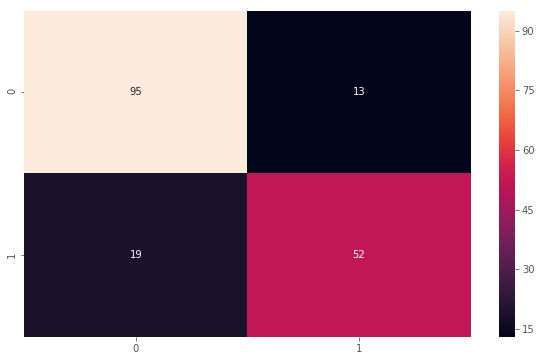

In [36]:
plt.figure(figsize=(10, 6))
confusion_m = metrics.confusion_matrix(valid["Survived"], valid_pred, labels=[0,1])
sns.heatmap(confusion_m, 
            annot = True)

### ML performance metrics

- Intuition taken from: https://www.geeksforgeeks.org/confusion-matrix-machine-learning/ 

1. **Precision**: TP/(TP + FP): 
    - What proportion of those **predicted** to survive, actually survived? 
    - The proportion of the predictions of that class that are accurate
2. **Recall** = TP/(TP + FN)
    - How many of those surviving the titanic are accurately predicted as survived?
    - The proportion of examples of that class that you're able to correctly label/recall
3. **F1-score** = (2 * Prec * Recall)/(Prec + Recall)
    - Aggregate preciaion and recall into 1 score
    - Harmonic Mean of precision and recall, which punishes extreme values more, meaning it'll always be closer to the lower value of the two
    
*High recall, low precision:* This means that most of the positive examples are correctly recognized (low FN) but there are a lot of false positives.

*Low recall, high precision:* This shows that we miss a lot of positive examples (high FN) but those we predict as positive are indeed positive (low FP)

In [37]:
print(metrics.classification_report(valid["Survived"], valid_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.88      0.86       108
         1.0       0.80      0.73      0.76        71

   micro avg       0.82      0.82      0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



In [38]:
print("Accuracy: ", metrics.accuracy_score(valid["Survived"], valid_pred)) 
print("Precision: ", metrics.precision_score(valid["Survived"], valid_pred))
print("Recall: ", metrics.recall_score(valid["Survived"], valid_pred))
print("F1_score: ", metrics.f1_score(valid["Survived"], valid_pred))
print("ROC_AUC: ", metrics.roc_auc_score(valid["Survived"], valid_pred))
print("Kappa: ", metrics.cohen_kappa_score(valid["Survived"], valid_pred))
print("MCC: ", metrics.matthews_corrcoef(valid["Survived"], valid_pred))

Accuracy:  0.8212290502793296
Precision:  0.8
Recall:  0.7323943661971831
F1_score:  0.7647058823529411
ROC_AUC:  0.8060119979134064
Kappa:  0.6210136297472542
MCC:  0.6225875017674073


### ROC curve

In [39]:
roc_auc = metrics.roc_auc_score(valid["Survived"], valid_pred)
fpr, tpr, thresholds = metrics.roc_curve(valid["Survived"], valid_pred_prob[:,1])

print(roc_auc)
print(fpr)
print(tpr)
print(thresholds)

0.8060119979134064
[0.         0.         0.         0.00925926 0.00925926 0.01851852
 0.01851852 0.02777778 0.02777778 0.03703704 0.03703704 0.0462963
 0.0462963  0.07407407 0.07407407 0.08333333 0.08333333 0.09259259
 0.09259259 0.11111111 0.11111111 0.12037037 0.12037037 0.12962963
 0.12962963 0.13888889 0.13888889 0.17592593 0.17592593 0.23148148
 0.23148148 0.33333333 0.33333333 0.34259259 0.34259259 0.39814815
 0.39814815 0.46296296 0.48148148 0.49074074 0.49074074 0.5
 0.5        0.58333333 0.62037037 0.65740741 0.65740741 0.75
 0.75       0.84259259 0.85185185 0.87037037 0.89814815 0.89814815
 0.97222222 0.99074074 1.        ]
[0.         0.01408451 0.18309859 0.18309859 0.38028169 0.38028169
 0.50704225 0.50704225 0.56338028 0.56338028 0.57746479 0.57746479
 0.61971831 0.61971831 0.63380282 0.63380282 0.66197183 0.66197183
 0.70422535 0.70422535 0.71830986 0.71830986 0.76056338 0.76056338
 0.8028169  0.8028169  0.81690141 0.81690141 0.83098592 0.83098592
 0.85915493 0.85915493

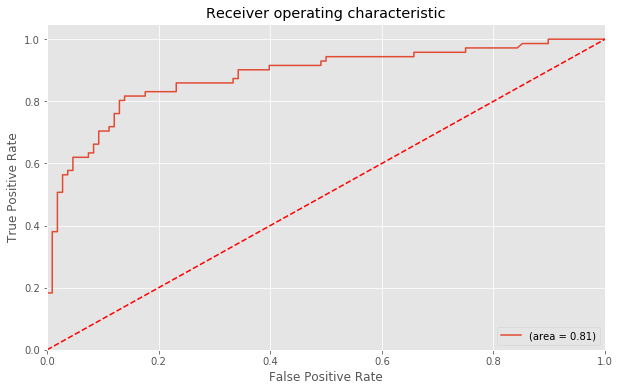

In [40]:
# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label = '(area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = "lower right")